<a href="https://colab.research.google.com/github/gon-uri/bird_detection/blob/main/Calssification_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1) Install libraries and download datasets

First we install torchaudio, a library with different pytorch resources for audio data. Then we also install kaggle library to dowload the enviromental sound dataset. Notice you will have to locate your "kaggle.json" API token on your root folder (to create and download your kaggle API token follow this instructions https://www.kaggle.com/docs/api).

In [2]:
!pip install torchaudio librosa boto3

! pip install -q kaggle
#! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d mmoreaux/environmental-sound-classification-50

 99% 1.41G/1.42G [00:09<00:00, 185MB/s]
100% 1.42G/1.42G [00:09<00:00, 165MB/s]


We unzip the content of the dataset.

In [3]:
!unzip environmental-sound-classification-50.zip

Se truncaron las últimas líneas 5000 del resultado de transmisión.
  inflating: audio/audio/16000/2-188822-C-40.wav  
  inflating: audio/audio/16000/2-188822-D-40.wav  
  inflating: audio/audio/16000/2-196688-A-8.wav  
  inflating: audio/audio/16000/2-205966-A-16.wav  
  inflating: audio/audio/16000/2-209471-A-25.wav  
  inflating: audio/audio/16000/2-209472-A-25.wav  
  inflating: audio/audio/16000/2-209473-A-25.wav  
  inflating: audio/audio/16000/2-209474-A-25.wav  
  inflating: audio/audio/16000/2-209475-A-25.wav  
  inflating: audio/audio/16000/2-209476-A-25.wav  
  inflating: audio/audio/16000/2-209477-A-25.wav  
  inflating: audio/audio/16000/2-209478-A-25.wav  
  inflating: audio/audio/16000/2-250710-A-39.wav  
  inflating: audio/audio/16000/2-25292-A-22.wav  
  inflating: audio/audio/16000/2-25293-A-22.wav  
  inflating: audio/audio/16000/2-262579-A-45.wav  
  inflating: audio/audio/16000/2-28314-A-12.wav  
  inflating: audio/audio/16000/2-28314-B-12.wav  
  inflating: audio/a

In [4]:
!nvidia-smi -L
!nvidia-smi

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-a6c83c74-89d8-70a8-9ef8-548d383531d8)
Thu Sep 23 18:32:51 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
           

# 2) Load datasets and display examples

In [1]:
!sudo pip install git+https://github.com/gon-uri/bird_detection --quiet

In [13]:
!pip uninstall birdect -y

Found existing installation: birdect 0.0.1
Uninstalling birdect-0.0.1:
  Successfully uninstalled birdect-0.0.1


In [2]:
from birdect.utils import print_stats, plot_waveform, plot_specgram
from birdect.utils_dataset import get_wind, get_background, get_bird_waveform
from birdect.utils_dataset import get_bird_location, get_background_location

In [4]:
# Needed imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
import torchaudio

from IPython.display import Audio
from scipy.io import wavfile
from tqdm import tqdm
import pickle
import glob

In [5]:
# Prepare the colab to play audios.

# Set to True if we are in colaboratory of False elsewere
colaboratory = True

if colaboratory:
    # Load the calc module
    !rm calc.*
    !wget https://raw.githubusercontent.com/R6500/Python-bits/master/Modules/calc.py

#Import the module
import calc

# Erase output after import
from IPython.display import clear_output
clear_output()

# Check loaded module
try:
    print('calc version: ',calc.version)
except:
    print('Error loading the calc module')

# Indicate the calc module if we are inside colaboratory
calc.setColaboratory(colaboratory)

calc version:  2/7/2018B


We inspect and listen to some sound of the dataset.

Sample Rate: 44100
Shape: (1, 220500)
Dtype: torch.float32
 - Max:      0.012
 - Min:     -0.013
 - Mean:    -0.000
 - Std Dev:  0.002

tensor([[0.0026, 0.0028, 0.0027,  ..., 0.0019, 0.0029, 0.0025]])



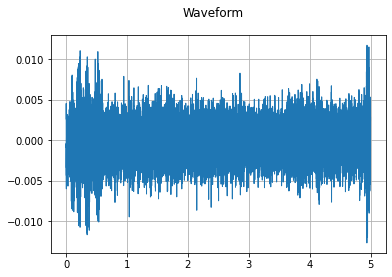

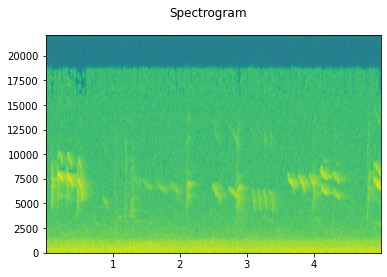

In [6]:
#Folder where audios are located
folder_audios = '/content/audio/audio/'

# Load the sounds data
df = pd.read_csv('esc50.csv')

# Select the data of the sound categories we will use
df_background = df[df['category']=='chirping_birds']['filename']
df_wind = df[df['category']=='wind']['filename']


# Select the soudn category for the example
category = df_background #df_wind

# Select an idx for example
file_num = 10

# Load and display audio properties
filename = category.iloc[file_num]
waveform, sample_rate = torchaudio.load(folder_audios + filename)
waveform = torch.nn.functional.normalize(waveform)
print_stats(waveform, sample_rate=sample_rate)
plot_waveform(waveform, sample_rate)
plot_specgram(waveform, sample_rate)
Audio(waveform,rate=sample_rate)

Now we load the dataset of the kind of birds we would like to identify. In this case, we will focus on Chingolos ([Zonotrichia capensis ](https://es.wikipedia.org/wiki/Zonotrichia_capensis)).

In [106]:
# Folder location of Target bird songs (train and test)
bird_train_folder = '/content/Chingolos/'
bird_test_folder = '/content/Chingolos_test/'

# Create lists containing birdsongs filenames
chingolos_filenames = glob.glob(bird_train_folder + "*.wav")
chingolos_filenames_test = glob.glob(bird_test_folder + "*.wav") 

We display the info of one of the songs as an example.

Sample Rate: 44100
Shape: (1, 81402)
Dtype: torch.float32
 - Max:      0.014
 - Min:     -0.014
 - Mean:     0.000
 - Std Dev:  0.004

tensor([[ 5.6267e-06,  2.5320e-05, -2.6727e-05,  ...,  3.2354e-05,
          1.1394e-04,  8.5808e-05]])



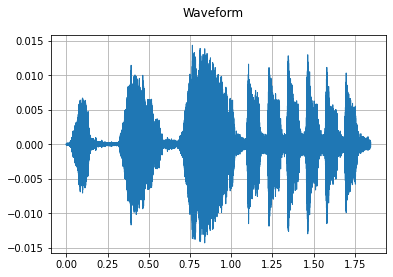

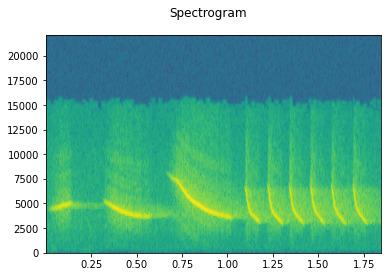

In [107]:
# Display a random example
file_num = 0
waveform2, sample_rate2 = torchaudio.load(chingolos_filenames[file_num])
waveform2 = torch.nn.functional.normalize(waveform2)
print_stats(waveform2, sample_rate=sample_rate2)
plot_waveform(waveform2, sample_rate2)
plot_specgram(waveform2, sample_rate2)
Audio(waveform2,rate=sample_rate)

# 3) Define Parameters and functions to create the dataset

We set the parameters we will use to create the training and test datasets.

In [108]:
# Sound sample length (in Seconds)
SOUND_LENGTH = 2.5 

# Proportion to bird level
WIND_LEVEL = 0.2 

# Proportion to bird level
BACKGROUND_LEVEL = 0.8

# Sampling rate of input sounds (in Hz)
SAMPLING_RATE = 20000 

# Batch size for data loaders
BATACH_SIZE = 100

# Number of Microphones in the array
MIC_NUM = 1

TOTAL_STEPS = int(SOUND_LENGTH*SAMPLING_RATE)

We create functions to get a random elements from the different datasets.

In [110]:
def add_sound(source_waveform, target_waveform, level):

    source_len = source_waveform.shape[1]

    if source_len > TOTAL_STEPS:
        extra_steps = source_len - TOTAL_STEPS - 1
        offset_steps = np.random.randint(0,extra_steps)
        target_waveform[0,:]  = target_waveform[0,:] + level * source_waveform[:,offset_steps:offset_steps+TOTAL_STEPS]        
    else:
        extra_steps = TOTAL_STEPS - source_len - 1
        offset_steps = np.random.randint(0,extra_steps)
        target_waveform[0,offset_steps:offset_steps+source_len] = target_waveform[0,offset_steps:offset_steps+source_len] + level * source_waveform[0,:]
   
    return target_waveform

The following function is the one in wich we compose one instance. The output sound is a sinthetic simulation of what would the array of microphones record in the field.  If present, we stage the sound source (a singing Chingolo) in the receptive field and compute the corresponding times delays between the emtion of the sound and the arrival to the different microphones. We also add a common background sound of real field recordings (with other birds singing) and wind noise (different for each of the microphones).

In [111]:
def generate_instance(bird_waveform, background_waveform, extra_background_waveform, wind_waveform, bird_present = True, background_extra = True):

    # Generates empty tensor to fill
    final_waveform = torch.zeros([MIC_NUM,TOTAL_STEPS])

    # Add bird sound (if present)
    if bird_present:
        final_waveform = add_sound(bird_waveform, final_waveform, level=1.0)

    # Add Extra Background sound (if present)
    if background_extra:
        bird_len = bird_waveform.shape[1]
        background_len = background_waveform.shape[1]
        extra_steps = background_len - bird_len - 1
        offset_steps = np.random.randint(0,extra_steps)
        cropped_background = background_waveform[:,offset_steps:offset_steps+bird_len]
        final_waveform = add_sound(cropped_background, final_waveform, level=1.0)
    
    # Add Backgroundm sound
    final_waveform = add_sound(background_waveform, final_waveform, level=BACKGROUND_LEVEL)

    # Add Wind sound
    final_waveform = add_sound(wind_waveform, final_waveform, level=WIND_LEVEL)

    return final_waveform

We also define a function to generate the complete dataset.

In [112]:
def generate_folder_dataset(num_instances, folder_name, chingolos_filenames, df_background, df_wind, percent_bird = 0.5, percent_background = 0.5):

    target_matrix = np.zeros([num_instances, 1])
    filenames_list = []

    for i in tqdm(range(num_instances)):
        wind_waveform = get_wind(df_wind, folder_audios, SAMPLING_RATE)
        background_waveform = get_background(df_background, folder_audios, SAMPLING_RATE)
        extra_background_waveform = get_background(df_background, folder_audios, SAMPLING_RATE)
        bird_waveform = get_bird_waveform(chingolos_filenames, SAMPLING_RATE)
        bird_present = np.random.choice([0,1],p=[(1-percent_bird), percent_bird])
        background_extra = np.random.choice([0,1],p=[(1-percent_background), percent_background])

        final_waveform = generate_instance(bird_waveform, background_waveform, extra_background_waveform, wind_waveform, bird_present = bird_present, background_extra = background_extra)

        filename_audio = folder_name + str(i) + '.wav'
        filenames_list.append(filename_audio)
        torchaudio.save(filename_audio, final_waveform, SAMPLING_RATE)
        target_matrix[i,:] = np.asarray([bird_present])

    return filenames_list, target_matrix

# 4) Create and save the Dataset

In [113]:
training_folder = '/content/train/'
filenames_list, target_matrix = generate_folder_dataset(5000, training_folder, chingolos_filenames, df_background, df_wind)

100%|██████████| 5000/5000 [09:36<00:00,  8.68it/s]


In [114]:
test_folder = '/content/test/'
filenames_list_test, target_matrix_test = generate_folder_dataset(1000, test_folder, chingolos_filenames_test, df_background, df_wind, percent_bird = 0.5)


100%|██████████| 1000/1000 [01:59<00:00,  8.36it/s]


In [115]:
with open('filenames_list.pickle', 'wb') as handle:
    pickle.dump(filenames_list, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('target_matrix.pickle', 'wb') as handle:
    pickle.dump(target_matrix, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('filenames_list_test.pickle', 'wb') as handle:
    pickle.dump(filenames_list_test, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('target_matrix_test.pickle', 'wb') as handle:
    pickle.dump(target_matrix_test, handle, protocol=pickle.HIGHEST_PROTOCOL)

# 5) [Extra] Load the dataset if it is already created

If you already created the dataset in a previous run, you can only load the filenames lists and the target matrices. 

In [ ]:
with open('filenames_list.pickle', 'rb') as handle:
    filenames_list = pickle.load(handle)

with open('target_matrix.pickle', 'rb') as handle:
    target_matrix = pickle.load(handle)

with open('filenames_list_test.pickle', 'rb') as handle:
    filenames_list_test = pickle.load(handle)

with open('target_matrix_test.pickle', 'rb') as handle:
    target_matrix_test = pickle.load(handle)

# 6) Define the Dataloader

Import Pytorch libraries

In [116]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


Create Dataset object

In [117]:
class ChingolosDataset(Dataset):
# Wrapper for the Chingolos dataset
    #  Argument List
    #  filenames_list with the list of WAVs file names in the folder
    #  target_matrix matrix with target values [bird_present, x_position, y_position, z_position]
    
    def __init__(self, filenames_list, target_matrix):
        self.filenames_list = filenames_list
        self.target_matrix = torch.tensor(target_matrix)
        # self.mixer = torchaudio.transforms.DownmixMono() #UrbanSound8K uses two channels, this will convert them to one

    def __getitem__(self, index):
        #format the file path and load the file
        path = self.filenames_list[index]
        sound = torchaudio.load(path, normalize  = True)
        # sound = sound.permute(1, 0) # NO SE ESTO PARA QUE ESTABA
        return sound[0].float(), self.target_matrix[index,:].float()
        # return sound[0].float(), self.target_matrix[index,0].float() # SOLO CLASIFiCACION
    
    def __len__(self):
        return len(self.filenames_list)


Instantiate the datasets and Dataloaders

In [118]:
# Create Datasets
train_set = ChingolosDataset(filenames_list, target_matrix)
test_set = ChingolosDataset(filenames_list_test, target_matrix_test)

print("Train set size: " + str(len(train_set)))
print("Test set size: " + str(len(test_set)))

# Create Dataloaders
#kwargs = {'num_workers': 1, 'pin_memory': True} if device == 'cuda' else {} # Needed for using datasets on gpu
train_loader = torch.utils.data.DataLoader(train_set, batch_size = BATACH_SIZE, shuffle = True)#, **kwargs)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = BATACH_SIZE, shuffle = True)#, **kwargs)

Train set size: 5000
Test set size: 1000


Inspect a random instance of the dataset.


Target:  tensor([1.])
Bird Present:  tensor(1.)
Bird Location:  tensor([])


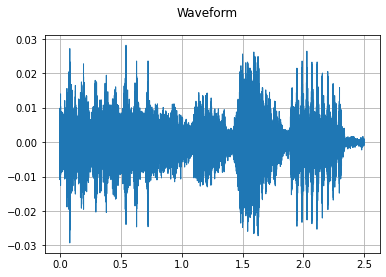

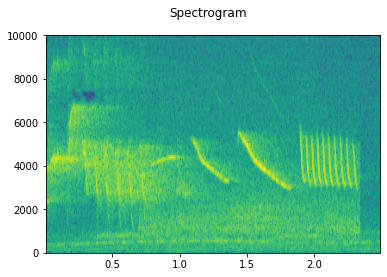

In [119]:
for data, target in train_loader:
    full_batch_waveform = data
    full_batch_targets = target
    break

idx = np.random.randint(BATACH_SIZE)
waveform = full_batch_waveform[idx]
waveform_ch1 = waveform[0:1]

print('Target: ',full_batch_targets[idx] )
print('Bird Present: ',full_batch_targets[idx][0])
print('Bird Location: ',full_batch_targets[idx][1:3])
plot_waveform(waveform_ch1, SAMPLING_RATE)
plot_specgram(waveform_ch1, SAMPLING_RATE)
Audio(waveform_ch1,rate=SAMPLING_RATE)

# 7) Define the model

We define a model that first uses 5 layers of 1D convolutions to generate 512 features of the waveform and then uses those features as an input for 2 fully connected layers. The first value of the output will be used to classify yes/no presence of a Chingolo, the following values will be used to predict the position of a bird, if present (if not, the target output is 0).

In [120]:
kernel_size = int(0.05*SAMPLING_RATE)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # self.conv0 = nn.Conv1d(4, 128, kernel_size, 10)
        self.conv1 = nn.Conv1d(1, 128, kernel_size, 10)
        self.bn1 = nn.BatchNorm1d(128, track_running_stats=True)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(128, 128, 3)
        self.bn2 = nn.BatchNorm1d(128, track_running_stats=True)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(128, 256, 3, 3)
        self.bn3 = nn.BatchNorm1d(256, track_running_stats=True)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(256, 512, 3)
        self.bn4 = nn.BatchNorm1d(512, track_running_stats=True)
        self.avgPool = nn.AvgPool1d(23) # input should be 512x33 so this outputs a 512x1
        self.fc1 = nn.Linear(512, 64)
        self.fc2 = nn.Linear(64, 4)
        
    def forward(self, x):
        # x = self.conv0(x)
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.avgPool(x)
        x = x.squeeze()
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

model = Net()
model.to(device)
print(model)

Net(
  (conv1): Conv1d(1, 128, kernel_size=(1000,), stride=(10,))
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(128, 128, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(128, 256, kernel_size=(3,), stride=(3,))
  (bn3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(256, 512, kernel_size=(3,), stride=(1,))
  (bn4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (avgPool): AvgPool1d(kernel_size=(23,), stride=(23,), padding=(0,))
  (fc1): Linear(in_features=512, out_features=64, bias=True)
  (fc2):

With torchsummmary we can have a 

In [121]:
from torchsummary import summary
wav_lenght = int(SOUND_LENGTH*SAMPLING_RATE)
summary(model, (1,wav_lenght), batch_size=BATACH_SIZE, device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1           [100, 128, 4901]         128,128
       BatchNorm1d-2           [100, 128, 4901]             256
         MaxPool1d-3           [100, 128, 1225]               0
            Conv1d-4           [100, 128, 1223]          49,280
       BatchNorm1d-5           [100, 128, 1223]             256
         MaxPool1d-6            [100, 128, 305]               0
            Conv1d-7            [100, 256, 101]          98,560
       BatchNorm1d-8            [100, 256, 101]             512
         MaxPool1d-9             [100, 256, 25]               0
           Conv1d-10             [100, 512, 23]         393,728
      BatchNorm1d-11             [100, 512, 23]           1,024
        AvgPool1d-12              [100, 512, 1]               0
           Linear-13                  [100, 64]          32,832
           Linear-14                   

In [122]:
!nvidia-smi -L
!nvidia-smi

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-a6c83c74-89d8-70a8-9ef8-548d383531d8)
Thu Sep 23 21:17:13 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    34W / 250W |   2321MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
           

# 8) Define training and test functions

In [123]:
optimizer = optim.Adam(model.parameters(), lr = 0.01, weight_decay = 0.0001)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 20, gamma = 0.1)
loss_fn_cat = nn.BCEWithLogitsLoss()

In [124]:
def train(model, epoch, loss_list, log_interval):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        data = data.to(device)
        target = target.to(device)
        output = model(data)

        loss = loss_fn_cat(output[:,0], target[:,0]) # CLASIFICATION LOSS
        loss.backward()
        
        optimizer.step()

        if batch_idx % log_interval == 0: #print training stats
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.detach().cpu()))
            
        loss_list.append(loss.detach().cpu())
            
        del data
        del target
        del output
        torch.cuda.empty_cache()

In [125]:
def test(model, epoch, val_loss_list, val_acc_list):
    model.train()
    correct_train = 0
    i = 0
    accum_accuracy = 0
    accum_loss_category = 0
    threshold = torch.tensor([0.0])
    
    for data, target in test_loader:
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        loss_category = loss_fn_cat(output[:,0], target[:,0]) # Solo CLASIFICACION
        pred = (output[:,0].detach().cpu()>threshold).float()*1

        accum_accuracy +=  pred.eq(target[:,0].detach().cpu()).cpu().sum()
        accum_loss_category +=  loss_category.detach().cpu()
        i += 1

        del data
        del target
        del output
        del pred
        torch.cuda.empty_cache()
    
    val_acc_list.append(accum_accuracy)
    val_loss_list.append(accum_loss_category)
    print('Test values for Epoch: ',epoch)
    print('Category Loss:',accum_loss_category/i)
    print('Accuraccy:',accum_accuracy/i)

# 9) Training Loop

In [126]:
loss_list = []
val_loss_list = []
val_acc_list = []
epoch_list = []
epoch = 1
log_interval = 20

In [127]:
for iter in range(1,10):
    train(model, epoch, loss_list, log_interval)
    test(model, epoch, val_loss_list, val_acc_list)
    epoch_list.append(epoch)
    epoch += 1


Train Epoch: 1 [0/5000 (0%)]	Loss: 0.695048
Train Epoch: 1 [2000/5000 (40%)]	Loss: 0.032212
Train Epoch: 1 [4000/5000 (80%)]	Loss: 0.008870
Test values for Epoch:  1
Category Loss: tensor(0.0383)
Accuraccy: tensor(99.2000)
Train Epoch: 2 [0/5000 (0%)]	Loss: 0.006905
Train Epoch: 2 [2000/5000 (40%)]	Loss: 0.014669
Train Epoch: 2 [4000/5000 (80%)]	Loss: 0.014351
Test values for Epoch:  2
Category Loss: tensor(0.0583)
Accuraccy: tensor(98.4000)
Train Epoch: 3 [0/5000 (0%)]	Loss: 0.000825
Train Epoch: 3 [2000/5000 (40%)]	Loss: 0.002574
Train Epoch: 3 [4000/5000 (80%)]	Loss: 0.000918
Test values for Epoch:  3
Category Loss: tensor(0.0625)
Accuraccy: tensor(98.2000)
Train Epoch: 4 [0/5000 (0%)]	Loss: 0.000312
Train Epoch: 4 [2000/5000 (40%)]	Loss: 0.006150
Train Epoch: 4 [4000/5000 (80%)]	Loss: 0.000253
Test values for Epoch:  4
Category Loss: tensor(0.0785)
Accuraccy: tensor(97.9000)
Train Epoch: 5 [0/5000 (0%)]	Loss: 0.007487
Train Epoch: 5 [2000/5000 (40%)]	Loss: 0.001621
Train Epoch: 5 [

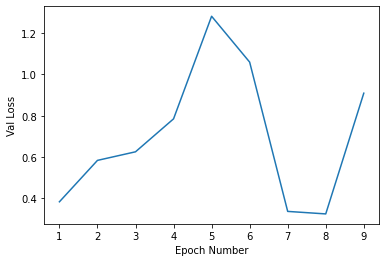

In [128]:
plt.plot(epoch_list,val_loss_list)
plt.ylabel('Val Loss')
plt.xlabel('Epoch Number')
plt.show()

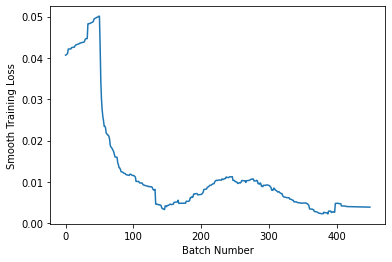

In [129]:
smoothed_loss = np.convolve(loss_list, np.ones(100), mode='same')
plt.plot(smoothed_loss/100)
plt.ylabel('Smooth Training Loss')
plt.xlabel('Batch Number')
plt.show()


### Save Model to Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"

In [ ]:
torch.save(model.state_dict(), root_dir + '/bird_detection/model_weights.pth')

### Testing Shapes

In [ ]:
        self.conv0 = nn.Conv1d(4, 128, kernel_size, 10)
        self.conv1 = nn.Conv1d(128, 128, 32, 2)
        self.bn1 = nn.BatchNorm1d(128, track_running_stats=True)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(128, 128, 3)
        self.bn2 = nn.BatchNorm1d(128, track_running_stats=True)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(128, 256, 3, 3)
        self.bn3 = nn.BatchNorm1d(256, track_running_stats=True)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(256, 512, 3)

In [67]:
2.5*SAMPLING_RATE

50000.0

In [68]:
tensor_prueba = torch.zeros([100, 1, TOTAL_STEPS])

conv1 = nn.Conv1d(1, 128, kernel_size, 10)
bn1 = nn.BatchNorm1d(128)
pool1 = nn.MaxPool1d(4)
conv2 = nn.Conv1d(128, 128, 3, 3)
bn2 = nn.BatchNorm1d(128)
pool2 = nn.MaxPool1d(4)
conv3 = nn.Conv1d(128, 256, 3)
bn3 = nn.BatchNorm1d(256)
pool3 = nn.MaxPool1d(4)
conv4 = nn.Conv1d(256, 512, 3)
bn4 = nn.BatchNorm1d(512)
# pool4 = nn.MaxPool1d(4)
avgPool = nn.AvgPool1d(35)
fc1 = nn.Linear(512, 64)
fc1 = nn.Linear(64, 32)
fc2 = nn.Linear(32, 4)

# x = conv0(tensor_prueba)
x = conv1(tensor_prueba)
x = F.relu(bn1(x))
x = pool1(x)
x = conv2(x)
x = F.relu(bn2(x))
x = pool2(x)
x = conv3(x)
x = F.relu(bn3(x))
x = pool3(x)
x = conv4(x)
x = F.relu(bn4(x))
# x = pool4(x)
# x = avgPool(x)
# x = x.squeeze()
# x = fc1(x)
# x = F.relu(x)
# x = fc2(x)

In [69]:
x.shape

torch.Size([100, 512, 23])